In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.time import Time
import lightkurve as lk
import tessreduce as tr
import astropy.units as u
from astropy.coordinates import SkyCoord
import sys
sys.path.append('/home/christandoi/spt3g_software/build') #this is for my janky VS code setup
from spt3g import core, maps, std_processing, util, transients, autoprocessing, sources
from spt3g.sources.catalog_matching import angular_separation

plt.rcParams.update({'font.size': 15,
                    'figure.figsize': (12,9),
                    'ytick.major.size' : 10,
                    'ytick.major.width' : 2,
                    'ytick.minor.size' : 5,
                    'ytick.minor.width' : 1,
                    'xtick.major.size' : 10,
                    'xtick.major.width' : 2,
                    'xtick.minor.size' : 5,
                    'xtick.minor.width' : 1})
orange = '#FFA500'

transients_db = pd.read_csv('/sptlocal/transfer/rsync/transfer_database/transients.txt', delimiter='\t')
transients_db['epoch'] = transients_db.apply(lambda row: Time(np.datetime64(row['time']), format='datetime64', scale='utc').unix, axis=1)
fields = ['ra0hdec-44.75', 'ra0hdec-52.25', 'ra0hdec-59.75', 'ra0hdec-67.25']
transients_db_winter = transients_db[transients_db['field'].isin(fields)]
transients_db_winter.rename(columns={'observation':'obsid'}, inplace=True)
short_duration_cut = transients_db_winter['fwhm[days]']>10.
long_duration_transients = transients_db_winter[short_duration_cut]
winter_gaia = sources.read_point_source_file(filename='/sptlocal/user/christandoi/1500d_gaia_dr3_mag20.txt')

mjy_convert = u.mJy.to(u.erg/u.s/u.Hz/u.pc/u.pc)
pc_to_cm = u.pc.to(u.cm)

find a good candidate to test out with TESS! first we'll cut on times that overlap with TESS. there's more cuts we can make to narrow down SPT transients that fall within the actual coordinates of TESS cameras, but that's a waste of time

In [68]:
long_duration_transients['mjd'] = long_duration_transients.apply(lambda row: std_processing.obsid_to_g3time(row['obsid']).mjd, axis=1)
long_duration_transients['epoch'] = Time(long_duration_transients['mjd'], format='mjd', scale='utc').unix

y3_start = Time({'year':2020, 'month':7, 'day':4}, format='ymdhms', scale='utc').unix
y3_end = Time({'year':2021, 'month':6, 'day':24}, format='ymdhms', scale='utc').unix
y3_mask = (long_duration_transients['epoch']>y3_start)&(long_duration_transients['epoch']<y3_end)
y5_start = Time({'year':2023, 'month':6, 'day':2}, format='ymdhms', scale='utc').unix
y5_end = Time({'year':2023, 'month':9, 'day':20}, format='ymdhms', scale='utc').unix
y5_mask = (long_duration_transients['epoch']>y5_start)&(long_duration_transients['epoch']<y5_end)
TESS_SPT_overlap = long_duration_transients[y3_mask|y5_mask]

s27_start = Time({'year':2020, 'month':7, 'day':4}, format='ymdhms', scale='utc').unix
s27_end = Time({'year':2020, 'month':7, 'day':30}, format='ymdhms', scale='utc').unix
s28_start = s27_end
s28_end = Time({'year':2020, 'month':8, 'day':26}, format='ymdhms', scale='utc').unix
s29_start = s28_end
s29_end = Time({'year':2020, 'month':9, 'day':22}, format='ymdhms', scale='utc').unix
s30_start = s29_end
s30_end = Time({'year':2020, 'month':10, 'day':21}, format='ymdhms', scale='utc').unix
s66_start = Time({'year':2023, 'month':6, 'day':2}, format='ymdhms', scale='utc').unix
s66_end = Time({'year':2023, 'month':7, 'day':1}, format='ymdhms', scale='utc').unix
s67_start = s66_end
s67_end = Time({'year':2023, 'month':7, 'day':29}, format='ymdhms', scale='utc').unix
s68_start = s67_end
s68_end = Time({'year':2023, 'month':8, 'day':25}, format='ymdhms', scale='utc').unix
s69_start = s68_end
s69_end = Time({'year':2023, 'month':9, 'day':20}, format='ymdhms', scale='utc').unix

TESS_epoch_ranges = {'27':(s27_start,s27_end),
                    '28':(s28_start,s28_end),
                    '29':(s29_start,s29_end),
                    '30':(s30_start,s30_end),
                    '66':(s66_start,s66_end),
                     '67':(s67_start,s67_end),
                     '68':(s68_start,s68_end),
                     '69':(s69_start,s69_end)}

now that we've got a list of only transients that overlap with TESS coverage, we'll apply various filtering and matching so we can have a better purity list of SPT-3G AGN

In [69]:
#we'll match to gaia for 2 reasons: there's an AGN/galaxy catalog so we want to look at high confidence (low p) matches on those. for other low p matches, we can probably rule them out as stars

TESS_SPT_overlap['DR3_source_id'] = -99999999999
TESS_SPT_overlap['DR3_source_id'] = TESS_SPT_overlap['DR3_source_id'].astype(np.int64)

TESS_SPT_overlap['num p<0.05'] = 0  #note any sources that have high multiple high confidence matches (only relevant for possible AGN matches if they preferentially match to a star first)

i=1
for index in TESS_SPT_overlap.index:
    cent_ra = TESS_SPT_overlap.at[index, 'centroid_ra[deg]'] #centroid coordinates use the TS map for a better localization than the reported pixel
    cent_dec = TESS_SPT_overlap.at[index, 'centroid_dec[deg]']
    searching_ra = cent_ra
    searching_dec = cent_dec
    if np.isnan(cent_ra):
        spt_ra = TESS_SPT_overlap.at[index, 'ra[deg]'] #some transients (old ones) don't have TS maps so we revert to pixel coords
        spt_dec = TESS_SPT_overlap.at[index, 'dec[deg]']
        searching_ra = spt_ra
        searching_dec = spt_dec
    obsid = TESS_SPT_overlap.at[index, 'obsid']
    if searching_ra<0:
        searching_ra += 360.
    ts = TESS_SPT_overlap.at[index, 'test_statistic']
    try:
        results = sources.get_gaia_prob(stars=winter_gaia, event_ra=searching_ra*core.G3Units.deg, event_dec=searching_dec*core.G3Units.deg, event_ts=ts, return_all=True, exgal_check=False) #exgal_check filters out sources from Gaia's extragalactic tables, so we turn it off for AGN
        candidate = results.iloc[0]
        TESS_SPT_overlap.at[index, 'DR3_source_id'] = candidate.name
        TESS_SPT_overlap.at[index, 'source_ra'] = candidate['ra[deg]']/core.G3Units.deg
        TESS_SPT_overlap.at[index, 'source_dec'] = candidate['dec[deg]']/core.G3Units.deg
        TESS_SPT_overlap.at[index, 'phot_g_mean_mag'] = candidate['g_mag']
        TESS_SPT_overlap.at[index, 'phot_bp_mean_mag'] = candidate['phot_bp_mean_mag']
        TESS_SPT_overlap.at[index, 'phot_rp_mean_mag'] = candidate['phot_rp_mean_mag']
        TESS_SPT_overlap.at[index, 'parallax'] = candidate['parallax']
        TESS_SPT_overlap.at[index, 'parallax_error'] = candidate['parallax_error']
        TESS_SPT_overlap.at[index, 'separation[arcsec]'] = candidate['dist[deg]']/core.G3Units.arcsec
        TESS_SPT_overlap.at[index, 'p-value'] = candidate['prob']
        TESS_SPT_overlap.at[index, 'qso'] = candidate['in_qso_candidates']
        TESS_SPT_overlap.at[index, 'galaxy'] = candidate['in_galaxy_candidates']
        low_p = results[results['prob']<0.05]
        TESS_SPT_overlap.at[index, 'num p<0.05'] = low_p.shape[0]
        print(f'{index}, {i}/{len(TESS_SPT_overlap)}, {candidate.prob}, {candidate.name}')
    except KeyError:
        print (index, ' no association TS available')
        continue
    i+=1

8, 1/267, 0.9428055783903949, 6501518499645505152
11, 2/267, 0.7597156630170363, 6507545811936077568
13, 3/267, 0.8784211729922305, 6513165072268669440
14, 4/267, 0.655382312506935, 6526002798235646592
15, 5/267, 0.4755373902450344, 4937222789749873664
16, 6/267, 0.5400162708170634, 6389501079642518784
17, 7/267, 0.4664130297811699, 4991795193969082112
18, 8/267, 0.2431307908439469, 4741244428466515456
19, 9/267, 0.6528877605425905, 4717395132202488192
20, 10/267, 0.45081384375285455, 6402937279237080320
21, 11/267, 0.4947218040514525, 6393092050259189632
22, 12/267, 0.1522560178353801, 4917383859069908864
25, 13/267, 0.21487367383402192, 6539696944978578688
26, 14/267, 0.6654639364338373, 6578199986756999296
28, 15/267, 0.8823562109986743, 4984359716523629696
29, 16/267, 0.8837668409670187, 4984359819602248192
31, 17/267, 0.165099613084773, 4982960519257505408
32, 18/267, 0.49840523529814107, 4917383790350432384
33, 19/267, 0.01975407335027833, 4690132775752548224
35, 20/267, 0.260270

In [70]:
AGN_galaxy = TESS_SPT_overlap[(TESS_SPT_overlap['qso']>0)|(TESS_SPT_overlap['galaxy']>0)].sort_values(by='p-value', ascending=True)

we'll go through our list, starting with the most likely candidate

In [71]:
online_spt_tess_candidate = pd.DataFrame()
online_spt_tess_candidate['obsid'] = -99999999999999
online_spt_tess_candidate['sector'] = -99999999999999
tess_obsids = []
tess_sectors = []
no_nearby_targets = []
sector_search_list = [27,28,29,30,66,67,68,69]
for index in AGN_galaxy.index:
    g_ra = AGN_galaxy.at[index,'source_ra']
    if g_ra<0:
        g_ra+=360.
    g_dec = AGN_galaxy.at[index,'source_dec']
    coords = SkyCoord(g_ra, g_dec, unit='deg')
    obsid = AGN_galaxy.at[index, 'obsid']
    spt_epoch = AGN_galaxy.at[index, 'epoch']
    tess_matches = lk.search_tesscut(coords, [sector for sector in sector_search_list])
    if len(tess_matches)<1:
        no_nearby_targets.append(obsid)
        print(obsid,' no nearby(.001") targets!')
    else:
        for mission in tess_matches.mission:
            sector = mission.split('TESS Sector ')[1]
            epoch_range = TESS_epoch_ranges[sector]
            if any(lower<spt_epoch<upper for (lower,upper) in [epoch_range]):
                print(obsid, sector)
                tess_obsids.append(obsid)
                tess_sectors.append(int(sector))
            else:
                print(obsid, ' no TESS overlap in time')
online_spt_tess_candidate['obsid'] = tess_obsids
online_spt_tess_candidate['sector'] = tess_sectors
online_spt_tess_candidate.sort_values(by='obsid', inplace=True, ascending=True)
online_spt_tess_candidate = pd.merge(online_spt_tess_candidate, AGN_galaxy, on='obsid')

206669994  no TESS overlap in time
206669994  no TESS overlap in time
207917768  no TESS overlap in time
207917768  no TESS overlap in time
207917768  no TESS overlap in time
210458912  no TESS overlap in time
210458912  no TESS overlap in time
210458912 69
209844371  no TESS overlap in time
209844371  no TESS overlap in time
209844371 69
209084838  no TESS overlap in time
209084838  no TESS overlap in time
209084838  no TESS overlap in time
204940971  no TESS overlap in time
204940971  no TESS overlap in time
209253779  no TESS overlap in time
209253779  no TESS overlap in time
204147131  no TESS overlap in time
204147131  no TESS overlap in time
203008216  no TESS overlap in time
204018376  no TESS overlap in time
205672389  no TESS overlap in time
205763489  no TESS overlap in time
205763489  no TESS overlap in time
205763489  no TESS overlap in time
207897877  no TESS overlap in time
207897877  no TESS overlap in time
209716466  no TESS overlap in time
209716466 69
205441470  no TE

lets check out our list of AGN candidates with TESS overlap

In [61]:
online_spt_tess_candidate

,obsid,sector,source,ra[deg],dec[deg],centroid_ra[deg],centroid_dec[deg],field,time,test_statistic,...,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_error,p-value,qso,galaxy,separation[arcsec],mjd
0,205039519,67,0246-70,41.65013,-70.90583,41.65247,-70.90634,ra0hdec-67.25,2023-07-01 15:27:19+00:00,79.4,...,19.593029,20.077925,18.884138,-0.322150,0.292359,0.113385,1.0,0.0,3.920082,60127.142581
1,205265945,67,0312-68,48.18166,-68.21607,48.18182,-68.21630,ra0hdec-67.25,2023-07-01 21:09:20+00:00,67.0,...,19.135592,19.555510,18.449312,0.136884,0.169515,0.096605,1.0,0.0,4.334649,60129.763252
2,205611984,67,0246-70,41.65217,-70.90007,41.65136,-70.90245,ra0hdec-67.25,2023-07-18 05:08:49+00:00,81.8,...,19.593029,20.077925,18.884138,-0.322150,0.292359,0.223328,1.0,0.0,11.199224,60133.768333
3,205620772,67,0312-68,48.18166,-68.21607,48.18198,-68.21639,ra0hdec-67.25,2023-07-02 04:20:45+00:00,68.8,...,19.135592,19.555510,18.449312,0.136884,0.169515,0.094771,1.0,0.0,4.035638,60133.870046
4,205620772,67,2118-70,319.62595,-70.38516,-40.37899,-70.38598,ra0hdec-67.25,2023-06-25 10:21:56+00:00,123.5,...,19.635141,19.717817,18.758171,-0.105862,0.334229,0.168469,1.0,0.0,6.925701,60133.870046
5,205620772,67,0312-68,48.18166,-68.21607,48.18198,-68.21639,ra0hdec-67.25,2023-07-02 04:20:45+00:00,68.8,...,19.135592,19.555510,18.449312,0.136884,0.169515,0.094771,1.0,0.0,4.035638,60133.870046
6,205620772,67,2118-70,319.62595,-70.38516,-40.37899,-70.38598,ra0hdec-67.25,2023-06-25 10:21:56+00:00,123.5,...,19.635141,19.717817,18.758171,-0.105862,0.334229,0.168469,1.0,0.0,6.925701,60133.870046
7,205629646,67,0246-70,41.65013,-70.90583,41.65267,-70.90631,ra0hdec-67.25,2023-07-08 23:24:38+00:00,87.7,...,19.593029,20.077925,18.884138,-0.322150,0.292359,0.112564,1.0,0.0,3.706622,60133.972755
8,206551572,67,0246-70,41.66024,-70.90333,41.66134,-70.90669,ra0hdec-67.25,2023-07-19 13:36:28+00:00,46.3,...,19.593029,20.077925,18.884138,-0.322150,0.292359,0.164515,1.0,0.0,9.546855,60144.643194
9,206773478,67,0312-68,48.18166,-68.21607,48.18530,-68.21672,ra0hdec-67.25,2023-07-21 21:56:12+00:00,87.7,...,19.135592,19.555510,18.449312,0.136884,0.169515,0.081787,1.0,0.0,0.556399,60147.211551


now we'll look at the highest confidence AGN (note: gaia matching is for stars, so there's gonna be some flaws and the p-value reported isn't the best but it's what we got)

In [72]:
test_AGN =  online_spt_tess_candidate.head(1) #separation of ~4 arcsec between source and spt event is pretty good

grab the TESS frame and run TESSreduce so we can look at the flux. this takes a while to run

getting TPF from TESScut
made reference
7
made source mask
calculating background
background subtracted
calculating centroids
!!Re-running for difference image!!
shifting images
7
remade mask
background
Background correlation correction
Field calibration
Target is below -30 dec, calibrating to SkyMapper photometry.


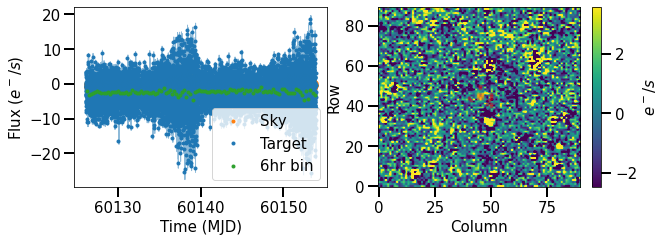

In [73]:
obsid = test_AGN['obsid'].values[0]
source_ra = test_AGN['source_ra'].values[0]
source_dec = test_AGN['source_dec'].values[0]
tess = tr.tessreduce(ra=source_ra, dec=source_dec, sector=67)
tess.reduce()

In [95]:
tess.to_flux()
lc = tess.lc
np.save('/sptlocal/user/christandoi/transients/data/test_AGN_tessreduce.npy', lc, allow_pickle=True) #save the data just in case

now let's look at SPT data

In [92]:
#from scrolling through the transients alerts channel to match to the event in the transients.txt database
flare_obsid=205039519
lc_file='ra0hdec-67.25/205629646.g3'
pixel=31973955
ts = 87.7

obs_file = f'/sptgrid/data/onlinemaps/lightcurve/{lc_file}'
g3_file = core.G3File(obs_file)

for obs_frame_candidate in g3_file:
    if obs_frame_candidate.type == core.G3FrameType.LightCurve and obs_frame_candidate['PixelIndex']==pixel:
        obs_frame = obs_frame_candidate
        # print(obs_frame['TestStatistic']) #check that we got the right one

flux, error, time = transients.lightcurve_tools.parse_lightcurve_data(obs_frame["LightCurve"], use_datetime=False)

obsids90 = [std_processing.time_to_obsid(time) for time in time['90GHz']]
obsids150 = [std_processing.time_to_obsid(time) for time in time['150GHz']]

if obsid in obsids90:
    idx90 = obsids90.index(obsid)
    f90 = flux['90GHz'][idx90]
    f90e = error['90GHz'][idx90]
if obsid in obsids150:
    idx150 = obsids150.index(obsid)
    f150 = flux['150GHz'][idx150]
    f150e = error['150GHz'][idx150]

mjd90 = [core.G3Time(time).mjd for time in time['90GHz']]
mjd150 = [core.G3Time(time).mjd for time in time['150GHz']]

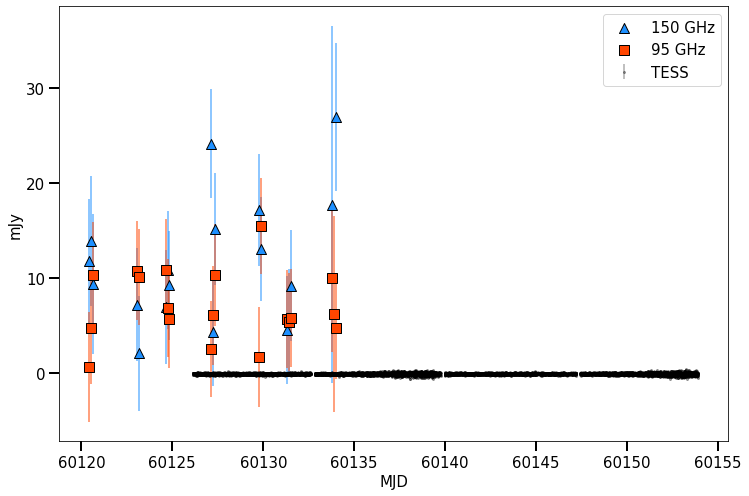

In [103]:
plt.figure(figsize=(12,8))
plt.errorbar(x=lc[0], y=lc[1], yerr=lc[2], fmt='o', ms=2, color='k', label='TESS', zorder=0, alpha=0.33)
# plt.scatter(x=lc[0], y=lc[1], edgecolor='k', s=15, color='white', label='TESS', zorder=0, alpha=0.33)
plt.errorbar(x=mjd150, y=flux['150GHz'],  yerr=error['150GHz'], fmt='o', ms=0, lw=2, alpha=0.5, color='dodgerblue', zorder=0)
plt.scatter(x=mjd150, y=flux['150GHz'], color='dodgerblue', s=100, marker='^', ec='k', lw=1, label='150 GHz')
plt.errorbar(x=mjd90, y=flux['90GHz'],  yerr=error['90GHz'], fmt='o', ms=0, lw=2, alpha=0.5, color='orangered', zorder=0)
plt.scatter(x=mjd90, y=flux['90GHz'], color='orangered', s=100, marker='s', ec='k', lw=1, label='95 GHz')
plt.ylabel('mJy')
plt.xlabel('MJD')
plt.legend(loc='upper right')

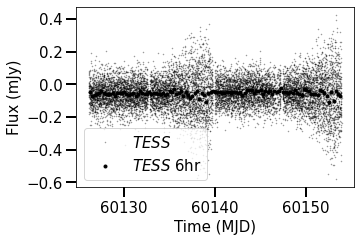

In [81]:
tess.plotter()

## Looking at 2019-2022 transients (optimized for short duration)

In [5]:
transient_pixels = pd.read_csv('/sptlocal/user/christandoi/transients/data/4year_transient_candidate_pixels.csv')

In [21]:
archival_AGN_candidates = transient_pixels[(transient_pixels['FWHM']>10)&(transient_pixels['TS']>30)]
bright_archival_AGN_candidates = archival_AGN_candidates[archival_AGN_candidates['On_source']==True]
dim_archival_AGN_candidates = archival_AGN_candidates[archival_AGN_candidates['On_source']==False]

In [9]:
archival_AGN_candidates

,Year,Field,Peak_Flux,TS,FWHM,On_source,obsid,ra,dec,centroid_ra,...,phot_rp_mean_mag,source_ra,source_dec,dist,association_TS,prlx,prlx_err,qso_flag,gal_flag,p-value
0,2019,ra0hdec-44.75,38.564220,137.401975,11.203571,True,71932544,329.829136,-46.025135,-30.169893,...,17.257044,329.828838,-46.026716,4.363988,3.292472,0.113072,0.089611,1.0,0.0,0.056329
1,2019,ra0hdec-44.75,23.941361,121.520625,17.731409,True,71941369,309.286028,-42.397730,-50.715116,...,16.793764,309.283321,-42.395938,11.801636,1.928188,0.570361,0.137988,0.0,0.0,0.174518
2,2019,ra0hdec-44.75,29.851164,115.642623,16.636467,True,72197111,348.225509,-44.880015,-11.774157,...,17.738764,348.228928,-44.877177,11.093387,1.684433,-0.100126,0.128183,1.0,0.0,0.196954
3,2019,ra0hdec-44.75,33.926804,95.107749,31.285774,True,71393139,1.584387,-42.756660,1.584942,...,18.031155,1.582234,-42.755161,8.203904,2.377221,-0.193423,0.155660,1.0,0.0,0.129955
4,2019,ra0hdec-44.75,24.026783,78.860690,42.197014,True,72059353,46.288589,-46.409764,46.289810,...,13.477525,46.289040,-46.415626,25.917762,-1.359984,1.030941,0.012592,0.0,0.0,0.424871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299464,2022,ra0hdec-67.25,22.714138,156.903696,19.352351,True,170642947,355.546247,-68.425578,-4.458425,...,17.398045,355.559863,-68.419038,29.696292,-10.892420,0.790120,0.117484,0.0,0.0,0.770942
299465,2022,ra0hdec-67.25,23.379172,145.961761,70.681233,True,171357499,354.897813,-66.952252,-5.098704,...,18.944283,354.898153,-66.952756,8.846369,1.732773,-0.001968,0.198368,1.0,0.0,0.192567
299466,2022,ra0hdec-67.25,22.346557,122.436339,10.072700,True,170992557,1.202118,-66.256202,1.205200,...,18.112051,1.204521,-66.257583,8.037592,2.013337,1.493286,0.247465,0.0,0.0,0.166566
299467,2022,ra0hdec-67.25,22.263447,74.296040,18.915522,True,170780612,326.186984,-69.779566,-33.813694,...,17.132397,326.161372,-69.787529,38.498345,-11.581071,0.261400,0.076690,0.0,0.0,0.784389


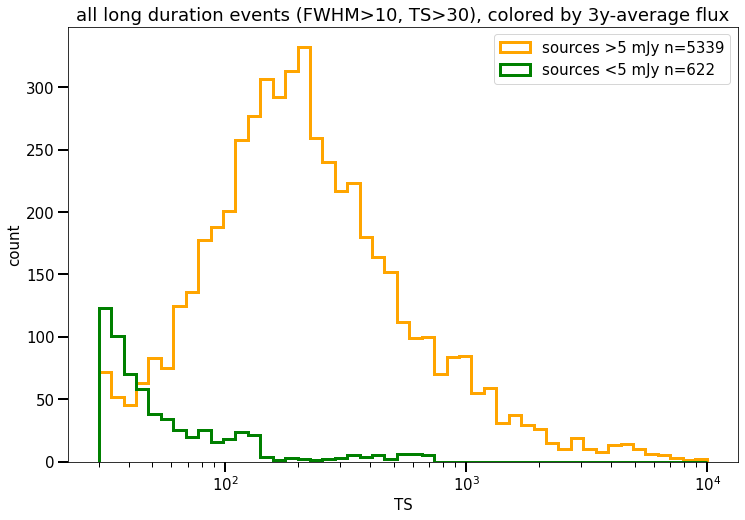

In [23]:
plt.figure(figsize=(12,8))
# plt.hist(archival_AGN_candidates['TS'], color='blue', histtype='stepfilled', lw=3, bins=np.logspace(np.log10(30), np.log10(1e4), 100), label=f'all long duration events (FWHM>10, TS>30)', alpha=0.33)
plt.hist(bright_archival_AGN_candidates['TS'], color='orange', histtype='step', lw=3, bins=np.logspace(np.log10(30), np.log10(1e4), 50), label=f'sources >5 mJy n={len(bright_archival_AGN_candidates)}')
plt.hist(dim_archival_AGN_candidates['TS'], color='green', histtype='step', lw=3, bins=np.logspace(np.log10(30), np.log10(1e4), 50), label=f'sources <5 mJy n={len(dim_archival_AGN_candidates)}')
plt.xlabel('TS')
plt.ylabel('count')
plt.xscale('log')
plt.title('all long duration events (FWHM>10, TS>30), colored by 3y-average flux')
plt.legend();